## Agenda
#### 1.Refresh sigmoid function and use in logistic regression.
#### 2. Brief overview of probability, odds, e, log, and log-odds
#### 3. Data cleaning
#### 4. Feature selection for linear models
#### 5. Feature Engineering and feature encoding
#### 6. Implement logistic regression using sklearn and stasmodel.api
#### 7. Evaluation metrics

# Logistic regression
Instead of fitting a line to the raw 1s and 0s of the data, logistic regression models the _probability_ that the outcome is 1 given the value of the predictor. Since probabilities have to be between 0 and 1, to do this we need a function that transforms our predictor variable (which in theory could range from −∞ to +∞) to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most appropriate choice when dealing with probabilities.

$$\textrm{theLogisticFunction}\thinspace(t) = \frac{1}{1 + e^{-t}}$$

In R, we implement this as `1 / (1 + exp(-t))` where `t` is our continuous predictor variable. We can apply the logistic function to transform the right side of the OLS regression equation, and use it to model the _probability_ of happiness instead of the raw `is_happy` value, as seen here:

$$P(\textrm{is_happy}) = \textrm{theLogisticFunction}(\textrm{intercept} + \textrm{slope} \times \textrm{beta})$$

In practice, the transformation is actually achieved by applying the “inverse logistic function” (aka, the “logit” function: $\textrm{logit}(p) = log(\frac{p}{1-p})$) to the left side of the equation (instead of applying the logistic function to the right side):

$$\textrm{logit}(P(\textrm{is_happy})) = \textrm{intercept} + \textrm{slope} \times \textrm{beta}$$

## Probability, odds, and log-odds
The left-hand side of the above equation, with the form $\textrm{logit}(P(\textrm{some_binary_outcome}))$ is also known as the “log-odds”. In gambling contexts, odds are usually given as “five-to-four in favor”; in statistics the meaning of odds is the same (expected number of “yes” results divided by expected number of “no” results), but the odds are reduced to a single number ($\textrm{“5-to-4”} = \frac{5}{4} = 1.25$) and “log-odds” is just $log(\textrm{odds})$. We can easily convert back and forth among log-odds, odds, and probability:

$$\begin{alignat}{3}
\textrm{odds} & = e^{\textrm{log odds}} && = \frac{\textrm{probability}}{1 - \textrm{probability}} \\
\textrm{log odds} & = log(\textrm{odds}) && = log(\frac{\textrm{probability}}{1 - \textrm{probability}}) \\
\textrm{probability} & = \frac{\textrm{odds}}{1 + \textrm{odds}} && = \frac{e^{\textrm{log odds}}}{1 + e^{\textrm{log odds}}}
\end{alignat}$$

In [0]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Plotly visualizations
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
zip_file = zipfile.ZipFile('/content/drive/My Drive/lending-club-loan-data.zip')
data = pd.read_csv(zip_file.open('loan.csv'), sep=",", error_bad_lines=False, low_memory=False,
                   parse_dates=["issue_d", "earliest_cr_line", "last_pymnt_d",
                                "next_pymnt_d", "last_credit_pull_d"])
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,2018-12-01,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,2001-04-01,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,2018-12-01,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,1987-06-01,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,2018-12-01,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,2011-04-01,0.0,NaN,NaN,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000.0,Source Verified,2018-12-01,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,985xx,WA,16.74,0.0,2006-02-01,0.0,NaN,NaN,10.0,0.0,5468,78.1,13.0,w,3831.93,3831.93,286.71,286.71,...,0.0,0.0,385183.0,36151.0,5000.0,44984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250.0,Not Verified,2018-12-01,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,212xx,MD,26.35,0.0,2000-12-01,0.0,NaN,NaN,12.0,0.0,829,3.6,26.0,w,29339.02,29339.02,1423.21,1423.21,...,0.0,0.0,157548.0,29674.0,9300.0,32332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data = pd.read_csv("./loan.csv", sep=",", error_bad_lines=False, low_memory=False,
                   parse_dates=["issue_d", "earliest_cr_line", "last_pymnt_d",
                                "next_pymnt_d", "last_credit_pull_d"])
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data.shape

(2260668, 145)

KNOW ABOUT YOUR DATA

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: datetime64[ns](5), float64(105), int64(4), object(31)
memory usage: 2.4+ GB


PRE-PROCESSING


NULL VALUES:

In [0]:
data.isnull().sum()

id                                            2260668
member_id                                     2260668
loan_amnt                                           0
funded_amnt                                         0
funded_amnt_inv                                     0
term                                                0
int_rate                                            0
installment                                         0
grade                                               0
sub_grade                                           0
emp_title                                      166969
emp_length                                     146907
home_ownership                                      0
annual_inc                                          4
verification_status                                 0
issue_d                                             0
loan_status                                         0
pymnt_plan                                          0
url                         

#### Unfortunately there are columns where most of values are NULLs. They are completely useless, so just remove those columns where more than 1% of the rows for that column contain a null value.

In [0]:
cleaned_data = data[[label for label in data if data[label].isnull().sum() <= 0.01 * data.shape[0]]]

In [0]:
cleaned_data.isnull().sum()

loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
home_ownership                   0
annual_inc                       4
verification_status              0
issue_d                          0
loan_status                      0
pymnt_plan                       0
purpose                          0
zip_code                         1
addr_state                       0
dti                           1711
delinq_2yrs                     29
earliest_cr_line                29
inq_last_6mths                  30
open_acc                        29
pub_rec                         29
revol_bal                        0
revol_util                    1802
total_acc                       29
initial_list_status              0
out_prncp                        0
out_prncp_inv       

#### Ok, much better. Now we have to do something with those NULL values. We can:
remove rows cointain NULL values,
fill them with median or mode value,
or use some imputation and try to predict their missing values.
Let's try first option and see what will happen.

In [0]:
cleaned_data = cleaned_data.dropna()
float(cleaned_data.shape[0]) / data.shape[0]

0.9967580378896858

#### It looks good, we removed less than 1% of rows. I think it's good enough and there's no point to do something more with that.

### Remove useless columns

#### lets take a look at data 

#### As we can see, two first columns contain randomly generated numbers, which are some identifiers. The column "url" also contains information about id,
#### What's more, "zip_code" is redundant with the "addr_state" and only 3 digits of 5 digit code zip are visible,
#### According to: https://www.lendingclub.com/public/rates-and-fees.action column sub_grade is reduntant to columns "grade" and "int_rate",
#### "title" column requires a lot of processing to become usefull.

In [0]:
cleaned_data = cleaned_data.drop(["sub_grade", "zip_code"], axis=1)
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,RENT,55000.0,Not Verified,2018-12-01,Current,n,debt_consolidation,NY,18.24,0.0,2001-04-01,1.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,2019-02-01,84.92,2019-02-01,0.0,1,Individual,0.0,0.0,0.0,1.0,0.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,MORTGAGE,90000.0,Source Verified,2018-12-01,Current,n,debt_consolidation,LA,26.52,0.0,1987-06-01,0.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,2019-02-01,777.23,2019-02-01,0.0,1,Individual,0.0,0.0,0.0,1.0,0.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,MORTGAGE,59280.0,Source Verified,2018-12-01,Current,n,debt_consolidation,MI,10.51,0.0,2011-04-01,0.0,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,2019-02-01,180.69,2019-02-01,0.0,1,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,MORTGAGE,92000.0,Source Verified,2018-12-01,Current,n,debt_consolidation,WA,16.74,0.0,2006-02-01,0.0,10.0,0.0,5468,78.1,13.0,w,3831.93,3831.93,286.71,286.71,168.07,118.64,0.0,0.0,0.0,2019-02-01,146.51,2019-02-01,0.0,1,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,MORTGAGE,57250.0,Not Verified,2018-12-01,Current,n,debt_consolidation,MD,26.35,0.0,2000-12-01,0.0,12.0,0.0,829,3.6,26.0,w,29339.02,29339.02,1423.21,1423.21,660.98,762.23,0.0,0.0,0.0,2019-02-01,731.78,2019-02-01,0.0,1,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N


## Columns with only one value
#### Or not only one, but with values which have insignificant frequencies.

In [0]:
for label in list(cleaned_data):
    if len(cleaned_data[label].unique()) < 5:
        print(cleaned_data[label].value_counts())
        print("\n")

 36 months    1604204
 60 months     649135
Name: term, dtype: int64


Source Verified    884549
Not Verified       740891
Verified           627899
Name: verification_status, dtype: int64


n    2252660
y        679
Name: pymnt_plan, dtype: int64


w    1531323
f     722016
Name: initial_list_status, dtype: int64


1    2253339
Name: policy_code, dtype: int64


Individual    2134713
Joint App      118626
Name: application_type, dtype: int64


N    2252458
Y        881
Name: hardship_flag, dtype: int64


Cash         2175369
DirectPay      77970
Name: disbursement_method, dtype: int64


N    2220376
Y      32963
Name: debt_settlement_flag, dtype: int64




We can see that feature "pymnt_plan" has only two possible values: "n" and "y", but with only 10 occurrences of "y" (less than 1%), so definitely it is insignificant. The same with "application_type" feature: value "joint" has 0,05% frequency. On the other hand, feature "policy_code" has only one possible value, so it's absolutely useless for us.

In [0]:
cleaned_data = cleaned_data.drop(["pymnt_plan", "policy_code", "application_type", "acc_now_delinq","hardship_flag","debt_settlement_flag"],
                                 axis=1)
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,disbursement_method
0,2500,2500,2500.0,36 months,13.56,84.92,C,RENT,55000.0,Not Verified,2018-12-01,Current,debt_consolidation,NY,18.24,0.0,2001-04-01,1.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,2019-02-01,84.92,2019-02-01,0.0,0.0,0.0,1.0,0.0,Cash
1,30000,30000,30000.0,60 months,18.94,777.23,D,MORTGAGE,90000.0,Source Verified,2018-12-01,Current,debt_consolidation,LA,26.52,0.0,1987-06-01,0.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,2019-02-01,777.23,2019-02-01,0.0,0.0,0.0,1.0,0.0,Cash
2,5000,5000,5000.0,36 months,17.97,180.69,D,MORTGAGE,59280.0,Source Verified,2018-12-01,Current,debt_consolidation,MI,10.51,0.0,2011-04-01,0.0,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,2019-02-01,180.69,2019-02-01,0.0,0.0,0.0,0.0,0.0,Cash
3,4000,4000,4000.0,36 months,18.94,146.51,D,MORTGAGE,92000.0,Source Verified,2018-12-01,Current,debt_consolidation,WA,16.74,0.0,2006-02-01,0.0,10.0,0.0,5468,78.1,13.0,w,3831.93,3831.93,286.71,286.71,168.07,118.64,0.0,0.0,0.0,2019-02-01,146.51,2019-02-01,0.0,0.0,0.0,0.0,0.0,Cash
4,30000,30000,30000.0,60 months,16.14,731.78,C,MORTGAGE,57250.0,Not Verified,2018-12-01,Current,debt_consolidation,MD,26.35,0.0,2000-12-01,0.0,12.0,0.0,829,3.6,26.0,w,29339.02,29339.02,1423.21,1423.21,660.98,762.23,0.0,0.0,0.0,2019-02-01,731.78,2019-02-01,0.0,0.0,0.0,0.0,0.0,Cash


In [0]:
cleaned_data.to_csv('./cleaned_output.csv', encoding='utf-8')

In [0]:
cleaned_data.columns

Index([u'loan_amnt', u'funded_amnt', u'funded_amnt_inv', u'term', u'int_rate',
       u'installment', u'grade', u'home_ownership', u'annual_inc',
       u'verification_status', u'issue_d', u'loan_status', u'purpose',
       u'addr_state', u'dti', u'delinq_2yrs', u'earliest_cr_line',
       u'inq_last_6mths', u'open_acc', u'pub_rec', u'revol_bal', u'revol_util',
       u'total_acc', u'initial_list_status', u'out_prncp', u'out_prncp_inv',
       u'total_pymnt', u'total_pymnt_inv', u'total_rec_prncp',
       u'total_rec_int', u'total_rec_late_fee', u'recoveries',
       u'collection_recovery_fee', u'last_pymnt_d', u'last_pymnt_amnt',
       u'last_credit_pull_d', u'collections_12_mths_ex_med',
       u'chargeoff_within_12_mths', u'delinq_amnt', u'pub_rec_bankruptcies',
       u'tax_liens', u'disbursement_method'],
      dtype='object')

### Numerical Variables And Categorical variables

In [0]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print(cleaned_data.select_dtypes(include=numerics).columns)
print('\n')
print(cleaned_data.select_dtypes(exclude=numerics).columns)

Index([u'loan_amnt', u'funded_amnt', u'funded_amnt_inv', u'int_rate',
       u'installment', u'annual_inc', u'dti', u'delinq_2yrs',
       u'inq_last_6mths', u'open_acc', u'pub_rec', u'revol_bal', u'revol_util',
       u'total_acc', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_amnt', u'collections_12_mths_ex_med',
       u'chargeoff_within_12_mths', u'delinq_amnt', u'pub_rec_bankruptcies',
       u'tax_liens'],
      dtype='object')


Index([u'term', u'grade', u'home_ownership', u'verification_status',
       u'issue_d', u'loan_status', u'purpose', u'addr_state',
       u'earliest_cr_line', u'initial_list_status', u'last_pymnt_d',
       u'last_credit_pull_d', u'disbursement_method'],
      dtype='object')


In [0]:
# cleaned_data.replace('n/a', np.nan,inplace=True)
# cleaned_data.emp_length.fillna(value=0,inplace=True)

# cleaned_data['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
# cleaned_data['emp_length'] = cleaned_data['emp_length'].astype(int)

cleaned_data['term'] = cleaned_data['term'].apply(lambda x: x.lstrip())

cleaned_data['year'] = cleaned_data.issue_d.dt.year

In [0]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


cleaned_data['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
cleaned_data['loan_condition'] = cleaned_data['loan_status'].apply(loan_condition)

[Text(0,0.5,'(%)')]

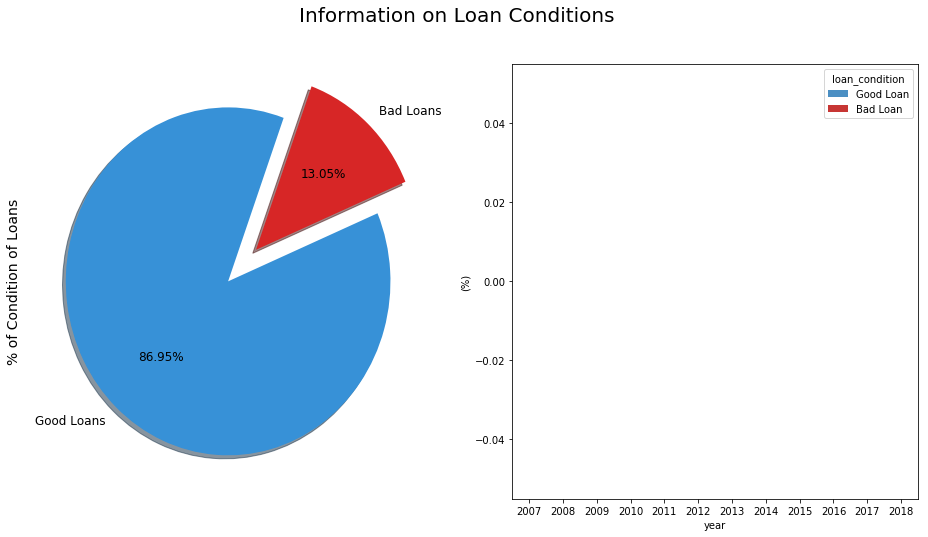

In [0]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

cleaned_data["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

# sns.countplot('loan_condition', data=df, ax=ax[1], palette=colors)
# ax[1].set_title('Condition of Loans', fontsize=20)
# ax[1].set_xticklabels(['Good', 'Bad'], rotation='horizontal')
palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="year", y="loan_amnt", hue="loan_condition", data=cleaned_data, palette=palette, estimator=lambda x: len(x) / len(cleaned_data) * 100)
ax[1].set(ylabel="(%)")

### Clearly the data is totally unbalanced!! 

#### This is a clear example where using a typical accuracy score to evaluate our classification algorithm. For example, if we just used a majority class to assign values to all records, we will still be having a high accuracy, BUT WE WOULD BE CLASSIFYING ALL "1" INCORRECTLY!!

#### There are several ways to approach this classification problem taking into consideration this unbalance. 

- Collect more data? Nice strategy but not applicable in this case
- Changing the performance metric:
    - Use the confusio nmatrix to calculate Precision, Recall
    - F1score (weighted average of precision recall)
    - Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
    - ROC curves - calculates sensitivity/specificity ratio.
    
- Resampling the dataset
    - Essentially this is a method that will process the data to have an approximate 50-50 ratio.
    - One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when you have little data)
    - Another is UNDER-sampling, which deletes instances from the over-represented class (better when he have lot's of data)

Text(0.5,1,'Total committed by Investors')

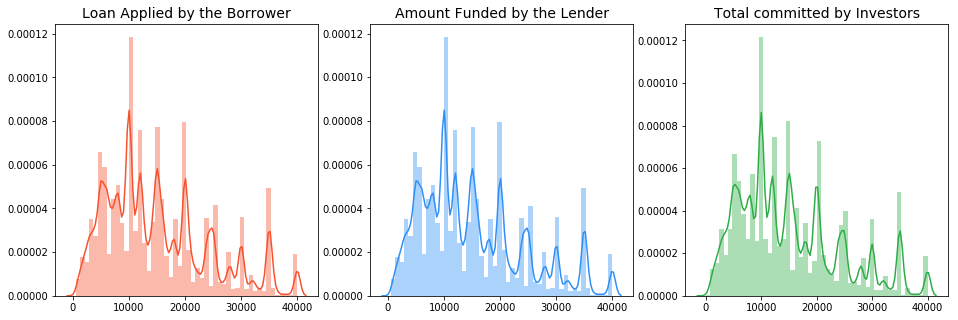

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))
loan_amount = cleaned_data["loan_amnt"].values
funded_amount = cleaned_data["funded_amnt"].values
investor_funds = cleaned_data["funded_amnt_inv"].values


sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14)

### As the distribution of above plots looks similar, it reveals that they might be correlated highly

Text(0,0.5,'Average loan amount issued')

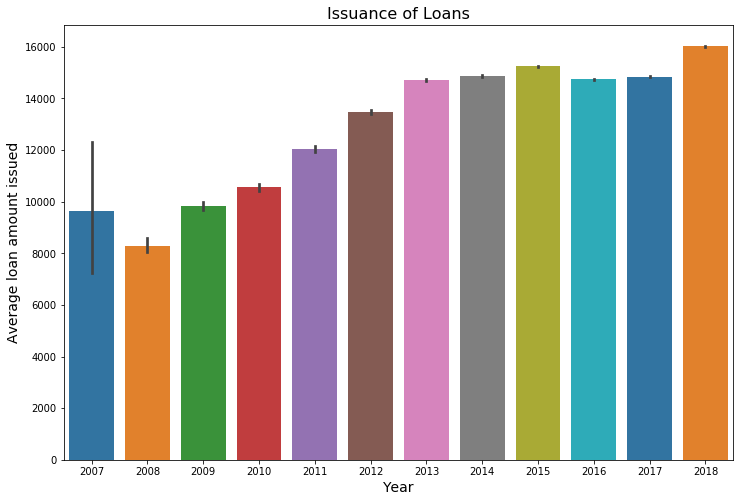

In [0]:
# The year of 2015 was the year were the highest amount of loans were issued 
# This is an indication that the economy is quiet recovering itself.
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amnt', data=cleaned_data, palette='tab10')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

In [0]:
cleaned_data['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

cleaned_data['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

cleaned_data['region'] = cleaned_data['addr_state'].apply(finding_regions)
cleaned_data.drop(['addr_state'], axis =1 , inplace=True)

## Datetime features
### We have datatype columns, but now it's useless - we have to extract some information from them.

In [0]:
print(cleaned_data.select_dtypes(include=["datetime"]).head())

datetime_features = list(cleaned_data.select_dtypes(include=["datetime"]))

for label in datetime_features:
    month_year = (cleaned_data[label].dt.month + cleaned_data[label].dt.year * 100)
    month_year_cnt_map = month_year.value_counts().to_dict()
    cleaned_data[label + "_month_year_cnt"] = month_year.map(month_year_cnt_map)
    
    cleaned_data[label + "_year"] = cleaned_data[label].dt.year
    cleaned_data[label + "_month"] = cleaned_data[label].dt.month

cleaned_data = cleaned_data.drop(datetime_features, axis=1)

     issue_d earliest_cr_line last_pymnt_d last_credit_pull_d
0 2018-12-01       2001-04-01   2019-02-01         2019-02-01
1 2018-12-01       1987-06-01   2019-02-01         2019-02-01
2 2018-12-01       2011-04-01   2019-02-01         2019-02-01
3 2018-12-01       2006-02-01   2019-02-01         2019-02-01
4 2018-12-01       2000-12-01   2019-02-01         2019-02-01


### Feature Engineering

In [0]:
cleaned_data['amt_difference'] = 'eq'
cleaned_data.loc[(cleaned_data['funded_amnt'] - cleaned_data['funded_amnt_inv']) > 0,'amt_difference'] = 'less'

#### * the metrics `delinq_2yrs` is very skewed towards zero (80% are zeros). Let's make it categorical: `no` when `delinq_2yrs == 0` and `yes` when  `delinq_2yrs > 0`

#### * Same as above for `inq_last_6mths`: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

#### * Same as above for `pub_rec`: Number of derogatory public records

In [0]:
# Make categorical

cleaned_data['delinq_2yrs_cat'] = 'no'
cleaned_data.loc[cleaned_data['delinq_2yrs']> 0,'delinq_2yrs_cat'] = 'yes'

cleaned_data['inq_last_6mths_cat'] = 'no'
cleaned_data.loc[cleaned_data['inq_last_6mths']> 0,'inq_last_6mths_cat'] = 'yes'

cleaned_data['pub_rec_cat'] = 'no'
cleaned_data.loc[cleaned_data['pub_rec']> 0,'pub_rec_cat'] = 'yes'

# Create new metric
cleaned_data['acc_ratio'] = cleaned_data.open_acc / cleaned_data.total_acc

### Correlation between numerical variables

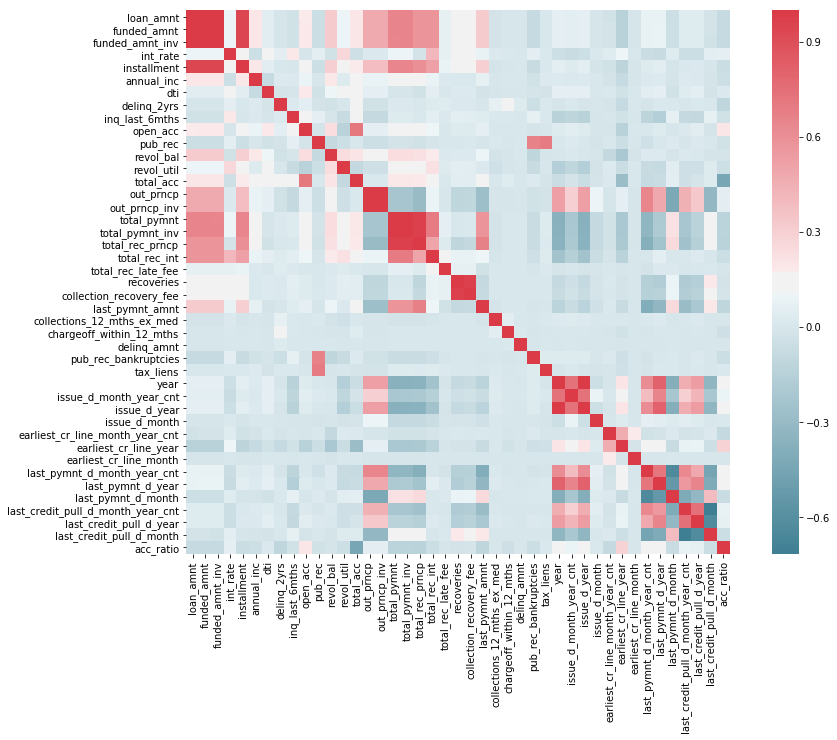

In [0]:
cleaned_data.drop(['year'], axis=1)
f, ax = plt.subplots(figsize=(15, 10))
corr = cleaned_data.corr()
corr_df = pd.DataFrame(corr)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [0]:
corr_df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,issue_d_month_year_cnt,issue_d_year,issue_d_month,earliest_cr_line_month_year_cnt,earliest_cr_line_year,earliest_cr_line_month,last_credit_pull_d_month_year_cnt,last_credit_pull_d_year,last_credit_pull_d_month,acc_ratio
loan_amnt,1.000000,0.999266,0.997171,0.145036,0.944950,0.126460,0.332668,0.020554,-0.000033,-0.034098,...,0.066370,0.102801,-0.002966,-0.025578,-0.168871,-0.012808,0.059523,0.074453,-0.045515,-0.095468
funded_amnt,0.999266,1.000000,0.998071,0.145176,0.945975,0.126633,0.332451,0.020951,0.000278,-0.034614,...,0.069161,0.107669,-0.003435,-0.025278,-0.168247,-0.012837,0.061511,0.077612,-0.046974,-0.094848
funded_amnt_inv,0.997171,0.998071,1.000000,0.145217,0.943656,0.127670,0.331450,0.022016,0.000776,-0.038648,...,0.076017,0.123677,-0.002367,-0.025049,-0.166811,-0.012942,0.066804,0.091317,-0.050335,-0.094669
int_rate,0.145036,0.145176,0.145217,1.000000,0.133066,0.007558,-0.072833,0.079936,0.055104,0.228000,...,-0.108317,-0.064137,-0.039035,0.029761,0.104435,0.000750,-0.048899,-0.019007,0.045650,0.067622
installment,0.944950,0.945975,0.943656,0.133066,1.000000,0.108489,0.326141,0.014210,0.008005,-0.003498,...,0.033335,0.074167,-0.012807,-0.027032,-0.150295,-0.013233,0.036186,0.056282,-0.025332,-0.077486
emp_length,0.126460,0.126633,0.127670,0.007558,0.108489,1.000000,0.091189,0.010197,0.028364,-0.007639,...,0.012104,0.031394,-0.003765,0.009836,-0.139173,-0.014953,0.026770,0.041388,-0.019178,-0.102881
annual_inc,0.332668,0.332451,0.331450,-0.072833,0.326141,0.091189,1.000000,-0.087360,0.047448,0.035336,...,0.030823,0.035886,0.008200,-0.041259,-0.144260,-0.015305,0.024409,0.022908,-0.021029,-0.098041
dti,0.020554,0.020951,0.022016,0.079936,0.014210,0.010197,-0.087360,1.000000,-0.002832,-0.008034,...,0.067919,0.078155,0.013089,0.002645,-0.013344,0.002692,0.052408,0.060230,-0.039312,0.023947
delinq_2yrs,-0.000033,0.000278,0.000776,0.055104,0.008005,0.028364,0.047448,-0.002832,1.000000,0.021336,...,0.054607,0.061670,0.008472,-0.017990,-0.081832,0.001688,0.041325,0.042067,-0.031771,-0.105673
inq_last_6mths,-0.034098,-0.034614,-0.038648,0.228000,-0.003498,-0.007639,0.035336,-0.008034,0.021336,1.000000,...,-0.116514,-0.137964,-0.022341,0.002750,-0.012013,-0.002528,-0.088113,-0.101406,0.071936,-0.028854


### Drop highly correlated features

In [0]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print(to_drop)

['funded_amnt', 'funded_amnt_inv', 'installment', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee', 'issue_d_year']


### Convert categorical variables into numerical variables

In [0]:
cleaned_data["initial_list_status"] = cleaned_data["initial_list_status"].map({"f": 1, "w": 0})
cleaned_data["loan_condition"] = cleaned_data["loan_condition"].map({"Good Loan":0, "Bad Loan":1})
to_drop.extend(["loan_status"])
print('bla:',to_drop)
cleaned_data.drop(labels=to_drop, axis=1, inplace=True)
# cleaned_data = pd.get_dummies(cleaned_data, columns=list(cleaned_data.select_dtypes(include=["object"])))

('bla:', ['funded_amnt', 'funded_amnt_inv', 'installment', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee', 'issue_d_year', 'loan_status'])


In [0]:
features = ['loan_amnt', 'amt_difference', 'term','grade',
            'home_ownership', 'annual_inc','verification_status',
            'purpose', 'dti', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 
            'open_acc', 'pub_rec', 'pub_rec_cat', 'acc_ratio', 'initial_list_status',  
            'loan_condition','int_rate','region','year','issue_d_month'
           ]
cleaned_data_sub = cleaned_data[features]

In [0]:
cleaned_data_sub = pd.get_dummies(cleaned_data_sub, columns=list(cleaned_data_sub.select_dtypes(include=["object"])))

### Train and test split

In [0]:
X = cleaned_data_sub.ix[:, cleaned_data_sub.columns != "loan_condition"]
y = cleaned_data_sub.ix[:, cleaned_data_sub.columns == "loan_condition"]

from sklearn.model_selection import train_test_split

# Whole dataset
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_Train))
print("Number transactions test dataset: ", len(X_Test))
print("Total number of transactions: ", len(X_Train)+len(X_Test))

('Number transactions train dataset: ', 1577337)
('Number transactions test dataset: ', 676002)
('Total number of transactions: ', 2253339)


In [0]:
logit_model = sm.Logit(y_Train.values.ravel(),X_Train)
result = logit_model.fit(maxiter=45)
print(result.summary())

         Current function value: 0.238534
         Iterations: 45
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               620594
Model:                          Logit   Df Residuals:                   620547
Method:                           MLE   Df Model:                           46
Date:                Fri, 29 Jun 2018   Pseudo R-squ.:                  0.1112
Time:                        03:24:34   Log-Likelihood:            -1.4803e+05
converged:                      False   LL-Null:                   -1.6655e+05
                                        LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
loan_amnt                            1.018e-05   8.11e-07     12.564      0.000     8.6e-06   

### Logistic Regression Model Fitting

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_Train, y_Train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Text(0.5,0,'Importance')

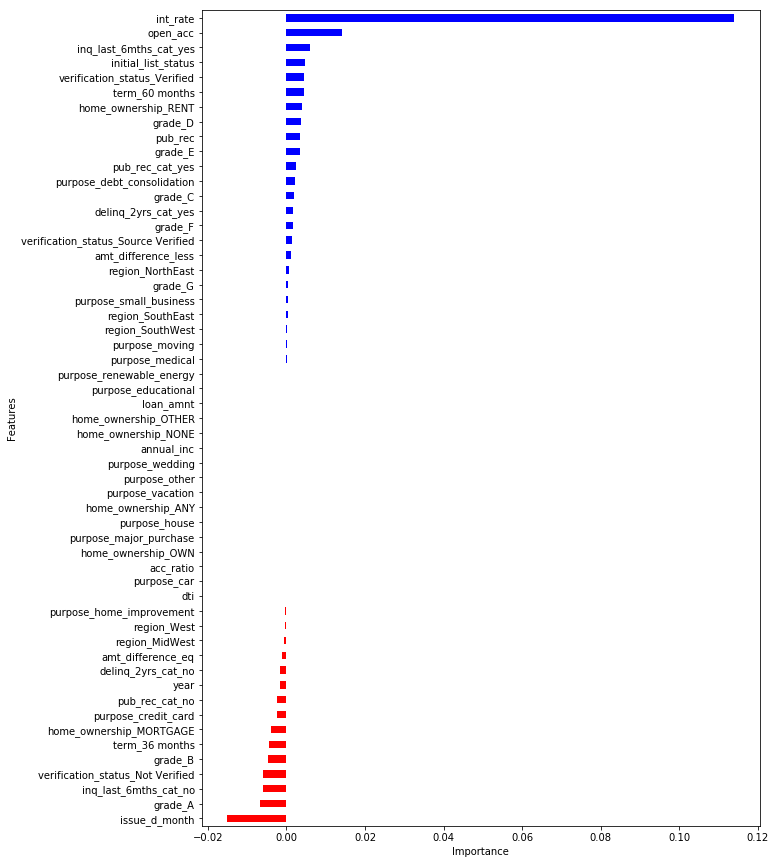

In [0]:
coeff = list(logreg.coef_[0])
labels = list(X_Train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(10,15),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')

In [0]:
y_pred = logreg.predict(X_Test)

In [0]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_Test, y_Test)))

Accuracy of logistic regression classifier on test set: 0.87


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_Test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93    587756
           1       0.32      0.01      0.01     88246

   micro avg       0.87      0.87      0.87    676002
   macro avg       0.60      0.50      0.47    676002
weighted avg       0.80      0.87      0.81    676002



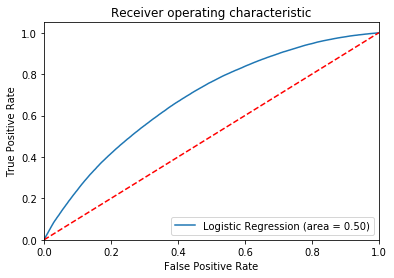

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_Test, logreg.predict(X_Test))
fpr, tpr, thresholds = roc_curve(y_Test, logreg.predict_proba(X_Test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

###  Confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

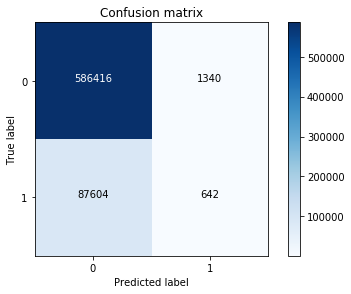

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_Test,y_pred)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()